# Flavor Shifts
## Applying the Shifterator package to ice cream reviews

The Shifterator (https://github.com/ryanjgallagher/shifterator) quantifies differences in two texts/collection of texts by applying information-theoretic metrics to the word frequencies. See the citation below.

> Gallagher, R. J., Frank, M. R., Mitchell, Lewis, Schwartz, A. J., Reagan, A. J., Danforth, C. M., Dodds, P. S.. (2020). Generalized Word Shift Graphs: A Method for Visualizing and Explaining Pairwise Comparisons Between Texts. arXiv preprint 2008.02250.

The ice cream dataset contains over 21,000 reviews of 200+ flavors across 4 brands (Ben & Jerry's, Häagen-Dazs, Breyers, and Talenti). I collected the data from the brand websites. The dataset currently lives on Kaggle (https://www.kaggle.com/tysonpo/ice-cream-dataset).

The purpose of this notebook is to identify which products are successful and interpret why they are successful. We aim to do this using the shifterator. :)

## Load packages

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter
import os
from nltk import ngrams # ngram function
from shifterator import ProportionShift, EntropyShift, JSDivergenceShift # shifterator
import cv2 # displaying product images

# Data directory and maximum ngram length parameter
DATADIR = "../../data"
NGRAM_LENGTH = 1 # change this for higher ngrams

## Load data

In [13]:
# Product and review data -- need to get product names and join with parsed reviews data
prod = pd.read_csv(os.path.join(DATADIR, "ice-cream-dataset-v2/combined/products.csv"))
prod = prod[["key","name"]]
rev = pd.read_csv(os.path.join(DATADIR, "ice-cream-dataset-v2/combined/reviews.csv"))
rev["doc_id"] = list(range(1,rev.shape[0]+1))
rev = rev[["key", "doc_id"]]
name_df = rev.merge(prod, how = "inner", on = "key")

# We'll use this later for UI
prod_names = prod["name"].values # for assert statement
name_to_key = {x:y for x,y in zip(prod["name"].values, prod["key"].values)} # for getting product image

# Parsed reviews
parsed_reviews = pd.read_csv(os.path.join(DATADIR, "parsed_reviews_for_topic_model.csv"), encoding="UTF-8", keep_default_na=False) 
parsed_reviews = parsed_reviews[["doc_id", "word"]]
parsed_reviews = parsed_reviews.merge(name_df, how = "inner", on = "doc_id")

## Functions for getting text ready for Shifterator

In [14]:
def get_ngrams(df, doc_id = "doc_id", word = "word", n=2):
    df_doc = df.groupby(doc_id)

    if n == 1:
        docs = df_doc.apply(lambda x: x[word].values.tolist()).values.tolist()
    else:
        ngram_df = pd.DataFrame(df_doc.apply(lambda x: x[word].values)).rename(columns={0:1})
        for i in range(2, n+1):
            ngram_df = ngram_df.join(pd.DataFrame(df_doc.apply(
            lambda x: ["_".join(ng) for ng in (ngrams(x[word], i))] )).rename(columns={0:i}) , on = doc_id)

        ngram_df = ngram_df.apply(lambda x: [w for ng in x for w in ng], axis = 1)

        docs = ngram_df.values.tolist()

    return docs

def prepare_systems(name1, name2, n=2):
    assert name1 in prod_names and name2 in prod_names, print("Product must be from:\n", prod_names)
    systems = []
    for name in [name1, name2]:
        df = parsed_reviews.loc[parsed_reviews["name"] == name] # subset to just this product
        docs = get_ngrams(df, doc_id = "doc_id", word = "word", n=n) # get ngrams for each document
        docs = [w for doc in docs for w in doc] # join ngrams from all documents into one big list
        systems.append(Counter(docs)) # append word counts
    return systems

## Choose two products

In [15]:
prod_names

array(['Salted Caramel Core', "Netflix & Chilll'd™", 'Chip Happens',
       'Cannoli', 'Gimme S’more!™', 'Peanut Butter Half Baked®',
       'Berry Sweet Mascarpone', 'Chocolate Peanut Butter Split',
       "Justice ReMix'd ™", 'Boots on the Moooo’n™', 'Americone Dream®',
       'Bourbon Pecan Pie', 'Brewed to Matter™',
       'Caramel Chocolate Cheesecake', 'Cherry Garcia®',
       "Chillin' the Roast™", 'Chocolate Chip Cookie Dough',
       'Chocolate Fudge Brownie', 'Chocolate Shake It™',
       'Chocolate Therapy®', 'Chubby Hubby®', 'Chunky Monkey®',
       'Cinnamon Buns®', 'Coffee Coffee BuzzBuzzBuzz!®',
       'Coffee Toffee Bar Crunch', 'Cold Brew Caramel Latte',
       'Everything But The...®', 'Glampfire Trail Mix™', 'Half Baked®',
       'Ice Cream Sammie', 'Milk & Cookies', 'Mint Chocolate Cookie',
       'Minter Wonderland™', 'New York Super Fudge Chunk®',
       'Oat of This Swirled™', 'Peanut Butter Cup',
       'Peanut Butter World®', 'Phish Food®', 'Pistachio Pistachio

In [16]:
flavor_1 = "Cherry Garcia®"
flavor_2 = "Phish Food®"
system_1, system_2 = prepare_systems(flavor_1, flavor_2, n=NGRAM_LENGTH)

In [17]:
print("Number of unique words in each system:", len(system_1), len(system_2))
print("Total number of words in each system:", sum(list(system_1.values())), sum(list(system_2.values())))

Number of unique words in each system: 216 56
Total number of words in each system: 382 81


In [18]:
print("Most common words for %s" % flavor_1)
system_1.most_common(10)

Most common words for Cherry Garcia®


[('love', 15),
 ('pint', 14),
 ('buy', 11),
 ('flavor', 11),
 ('like', 9),
 ('favorite', 8),
 ('taste', 8),
 ('eat', 7),
 ('purchase', 7),
 ('week', 5)]

## Make plot

In [21]:
def make_flavor_shift_plot(ax, titles):
    shift = JSDivergenceShift(system_1, system_2)
#     shift = EntropyShift(system_1, system_2)
    shift.get_shift_graph(system_names=titles, ax=ax, show_plot=False)

C:\Users\tysonp\Anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


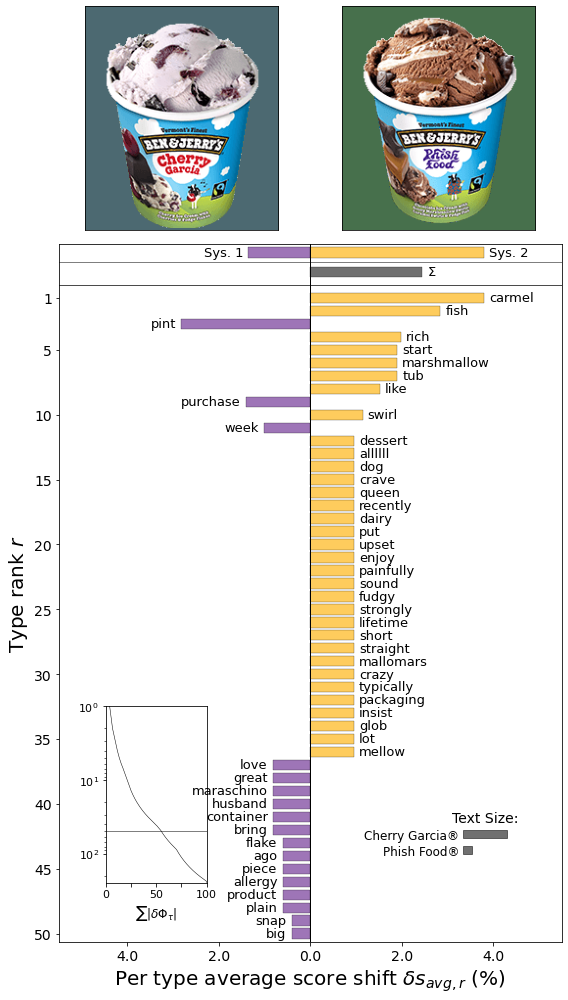

In [22]:
# initialize figure & gridspec
fig = plt.figure(constrained_layout=True, figsize=(8,14))
gs = fig.add_gridspec(4, 2) # fiddle around with number of rows, figsize, spacing, and constrained_layout

# initialize subplot axes
f_ax0 = fig.add_subplot(gs[0, 0])
f_ax1 = fig.add_subplot(gs[0, 1])
f_ax2 = fig.add_subplot(gs[1:, :])

# flavor 1
img1 = cv2.imread(os.path.join(DATADIR, "ice-cream-dataset-v2/combined/images/%s.png" % name_to_key[flavor_1]))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
plt.sca(f_ax0)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])

# flavor 2
img2 = cv2.imread(os.path.join(DATADIR, "ice-cream-dataset-v2/combined/images/%s.png" % name_to_key[flavor_2]))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
plt.sca(f_ax1)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])

# word shift
make_flavor_shift_plot(f_ax2, titles=[flavor_1, flavor_2])

# save/display
# plt.savefig("flavor_shift_plot.pdf")
plt.show()